In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import matplotlib.ticker as ticker
import re
import numpy as np
from IPython.display import display, HTML
import re
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib as mpl
sns.set_style("darkgrid")
mpl.rcParams["legend.loc"] = 'upper right' 
from IPython.core.display import display, HTML

C:\Users\gosia\AppData\Local\Temp\ipykernel_25236\3482101299.py:15: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [3]:
!pip install Jinja2

# plot


In [4]:
def display_table_resluts(logs,columns =['type','probability','threshold','B_1','B_45','B_52'], col_to_format =  ['B_1','B_45','B_52']):
    table = logs[columns]
    for col in col_to_format:
        table[col] = table[col].apply(lambda x : '{:.2f}'.format(x))
    display(HTML(table.to_html()))
    return table

In [5]:
mapper = dict(zip(["<class 'river.forest.adaptive_random_forest.ARFClassifier'>",
 "<class 'river.tree.hoeffding_adaptive_tree_classifier.HoeffdingAdaptiveTreeClassifier'>",
 "<class 'river.naive_bayes.gaussian.GaussianNB'>", "<class 'river.dummy.PriorClassifier'>"],['ARF','HT','NB','Majority']))

In [6]:
def create_partial_plot(method,dataset,tmp,descriptive_vars,types,agg_type,metric,with_saving, title):
    tmp['types_of_data'] = tmp.apply(lambda r: "_".join([str(r[col]) if not pd.isna(r[col]) else "" for col in descriptive_vars ]) ,axis =1)
    tmp = tmp.replace(" ",None)
    tmp = tmp[tmp['type'].apply(lambda x : x in types)]
    tmp = tmp.drop(columns=descriptive_vars)
    tmp = tmp.melt(id_vars = 'types_of_data')
    tmp = tmp.rename(columns = {'types_of_data':'threshold'})
    tmp['variable'] = tmp['variable'].apply(lambda x : x.split('_')[1])
    if agg_type == 'labelled instances':
        tmp['variable'] = 100*tmp['variable'].astype(int) #.rolling(10,min_periods=1).mean()
    # tmp['threshold'] = tmp['threshold'] .apply(lambda x: x.split('_')[1])
    fig, ax = plt.subplots(1,1,figsize=(15,2), sharey=True,sharex=True)  
    g = sns.lineplot(data = tmp, x = 'variable', y = 'value',hue = 'threshold',ax = ax,palette='tab10')   
    g.set(ylim=(0, 1),ylabel= metric,xlabel=agg_type)   

    if with_saving:
        plt.savefig(os.path.join('images',dataset,method,f"{title}.pdf"), format="pdf", bbox_inches="tight")
    plt.show()
    # else:
    #     g.set(ylim=(0, 1),ylabel= metric,xlabel=agg_type,xticklabels=[])
    

    


In [7]:
def plot_bins_diff(logs,method,dataset, agg_type = "bins",metric = 'Acc',types = ['ssl','delay'], filter = None, descriptive_vars = [],
                    with_saving = False, save_table = False, columns_of_table = ['type','probability','B_1','B_45','B_52']):
    to_keep = [d for d in descriptive_vars]
    if filter:
        to_keep.append(filter)
    logs = logs.sort_values(by = to_keep)
    if agg_type == 'bins':
        bins_cols = [x for x in logs.columns if x.startswith("B_")]

        to_keep.extend(bins_cols)
    elif agg_type == 'labelled instances':
        to_keep.extend([x for x in logs.columns if x.startswith("m_")])
    partial_logs = logs[to_keep]

    if filter is None:
        create_partial_plot(method,dataset,partial_logs,descriptive_vars,types,agg_type,metric,with_saving, 0)

    else:
        filters = [f  for f  in partial_logs[filter].unique() if not pd.isna(f)]

        for i,f in enumerate(filters):
            tmp = partial_logs[partial_logs[filter]==f]
            tmp = tmp.drop(columns =[filter])
            create_partial_plot(method,dataset,tmp,descriptive_vars,types,agg_type,metric,with_saving,f)

            

 
    # plt.suptitle(title, size=16, y=1.2)
    # if with_saving:
    #     plt.savefig(os.path.join('images',dataset,f"{title}_{agg_type}_{metric}_{'_'.join(types)}.pdf"), format="pdf", bbox_inches="tight")
    # plt.show()
    if save_table:
        table = display_table_resluts(logs,columns =columns_of_table)
    return table

In [8]:
def create_partial_plot_classifers_comp(tmp,id_column,agg_type,metric, dataset,filter,with_saving):
    # if metric == 'Kappa':
    #     tmp[id_column] = tmp[id_column].apply(lambda x: x.split('_')[0])
    if agg_type == 'bins':
        bins_cols = [x for x in tmp.columns if x.startswith("B_")]
        new_bins = [f'B_{i}' for i in range(1,len(bins_cols)+1)]
        tmp =tmp.rename(columns = dict(zip(bins_cols,new_bins)))
    tmp = tmp.melt(id_vars = id_column)
    tmp['variable'] = tmp['variable'].apply(lambda x : x.split('_')[1])
    if agg_type == 'labelled instances':
        tmp['variable'] = 100*tmp['variable'].astype(int) #.astype(int).rolling(6,min_periods=1).mean()

    tmp = tmp[tmp['value']!=' ']
    tmp = tmp.dropna()
    fig, ax = plt.subplots(1,1,figsize=(10,5), sharey=True,sharex=True) 
    
    g = sns.lineplot(data = tmp, x = 'variable', y = 'value',hue = id_column,palette='tab10', ax = ax)   
    all_vars = tmp['variable'].unique()
    all_vars =all_vars[::int(len(all_vars)/10)]
    if  metric == 'Kappa':
         g.set(ylim=(-0.3, 1),ylabel= metric,xlabel=agg_type,xticks  = all_vars)
    else:
        g.set(ylim=(-0.1, 1),ylabel= metric,xlabel=agg_type,xticks  = all_vars)
    sns.move_legend(ax, "lower center", bbox_to_anchor=(.5, 1.2), ncol=4, title=None, frameon=False,fontsize="15")
    if with_saving:
        directory = os.path.join('images','method comparison',metric,agg_type,dataset)
        if not os.path.exists(directory):
            os.makedirs(directory)
        plt.savefig(os.path.join(directory,f"{filter}.pdf"), format="pdf", bbox_inches="tight")
    plt.show()

In [9]:
def plot_method_comparison(logs,dataset, agg_type = "bins",metric = 'Acc', filter_name = 'classifier', descriptive_var = 'type_and_probability',
                    with_saving = False, save_table = False, columns_of_table = ['type_and_probability','probability','B_1','B_45','B_52']):
    to_keep = [ descriptive_var]
    if filter_name:
        to_keep.append(filter_name)
    logs = logs.sort_values(by = to_keep)
    

    filters = [f  for f  in logs[filter_name].unique() if not pd.isna(f)]
    for i,f in enumerate(filters):
        print(f)
        to_keep = [ descriptive_var]
        if filter_name:
            to_keep.append(filter_name)
        tmp = logs[logs[filter_name]==f]
        if agg_type == 'bins':
            bins_cols = [x for x in tmp.columns if x.startswith("B_")]
            # bins_cols = list(tmp[bins_cols].columns[(tmp[bins_cols] == 0).sum()<2])
            to_keep.extend(bins_cols)
        elif agg_type == 'labelled instances':
            to_keep.extend([x for x in logs.columns if x.startswith("m_")])
        tmp = tmp[to_keep]
        
        tmp = tmp.drop(columns =[filter_name])
        create_partial_plot_classifers_comp(tmp,descriptive_var,agg_type,metric,dataset,f, with_saving) 

In [10]:
types = ['ssl']
thresholds = [0.5,0.7]
probabilities = [0,0.1,0.2]

In [11]:

def get_latex(df, label, caption):
    
    tabular = df.to_latex(index=False,float_format="%.2f")
    table = "\\begin{table}\n" + "\centering\n" + tabular + f"\caption{{{caption}}}\n" + f"\label{{{label}}}\n" + "\\end{table}"
    table = table.replace("+-", "$\pm$")
    print(table)

In [12]:
ACC_dict = {
    'ARF': 'IARF',
    'ICLC':'ICLC_ARF',
    'NB': 'INB',
    'HT': 'IHT',
    'Majority': 'IMajority',
    'NoChange': 'INoChange',
    'Clustream':'Clustream'
}

In [13]:
Kappa_dict = {
    'ARF_kappa': 'IARF',
    'ICLC_kappa':'ICLC_ARF',
    'NB_kappa': 'INB',
    'HT_kappa': 'IHT',
    'Majority_kappa': 'IMajority',
    'NoChange_kappa': 'INoChange',
    'Clustream_kappa': 'Clustream'
}

LED_gradual


C:\Users\gosia\AppData\Local\Temp\ipykernel_25236\1172360422.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['classifier'] = tmp['classifier'].apply(lambda x : x.replace('_','\_'))


________________ LED_gradual ____________________
\begin{table}
\centering
\begin{tabular}{lrrrrr}
\toprule
classifier & probability & B_1 & B_15 & B_40 & B_52 \\
\midrule
INoChange & 0.10 & -0.00 & -0.00 & 0.00 & 0.00 \\
INB & 0.10 & 0.45 & 0.46 & 0.48 & 0.48 \\
IMajority & 0.10 & -0.00 & -0.00 & -0.00 & -0.00 \\
IHT & 0.10 & 0.49 & 0.49 & 0.51 & 0.52 \\
ICLC\_ARF & 0.10 & 0.61 & 0.63 & 0.64 & 0.64 \\
IARF & 0.10 & 0.63 & 0.66 & 0.67 & 0.67 \\
Clustream & 0.10 & 0.03 & 0.09 & 0.11 & 0.11 \\
INoChange & 0.20 & 0.00 & -0.00 & -0.00 & 0.00 \\
INB & 0.20 & 0.43 & 0.43 & 0.45 & 0.45 \\
IMajority & 0.20 & -0.00 & -0.00 & -0.00 & -0.00 \\
IHT & 0.20 & 0.45 & 0.46 & 0.48 & 0.49 \\
ICLC\_ARF & 0.20 & 0.60 & 0.61 & 0.63 & 0.63 \\
IARF & 0.20 & 0.60 & 0.62 & 0.64 & 0.64 \\
Clustream & 0.20 & 0.03 & 0.08 & 0.10 & 0.10 \\
\bottomrule
\end{tabular}
\caption{Kappa for LED_gradual}
\label{tab:res_1:LED_gradual}
\end{table}
0.1


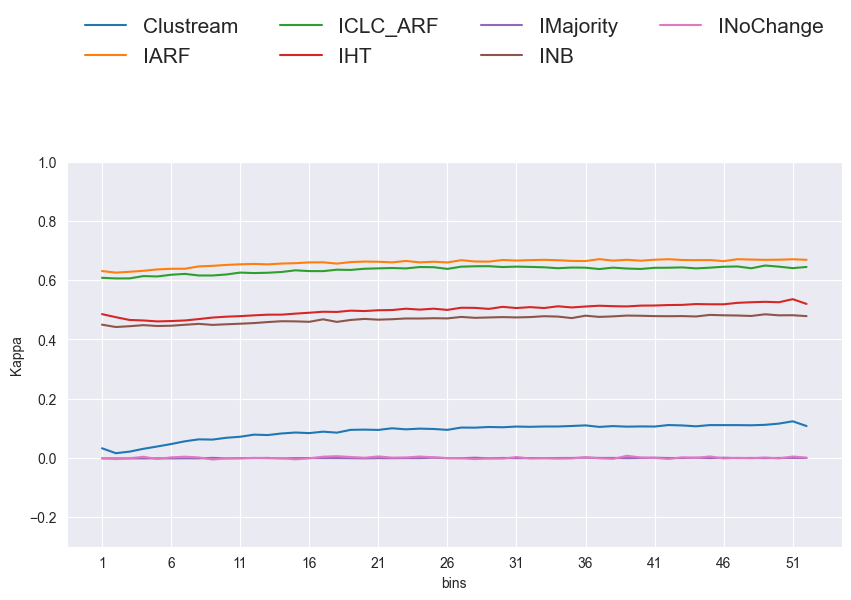

0.2


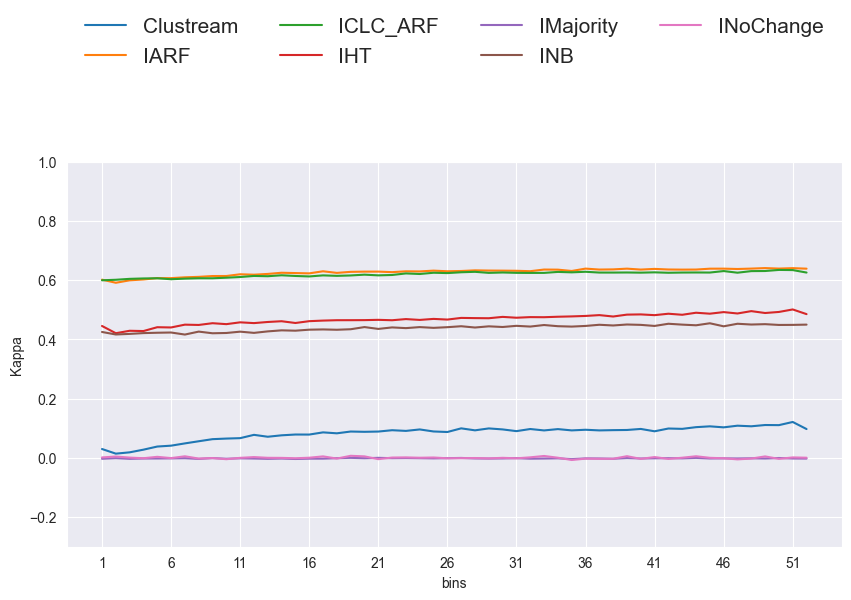

In [14]:
mpl.rcParams["legend.loc"] = 'best' 
metric = 'Kappa'
with_saving_table = True
with_rolling = True
agg_type = 'bins'
for dataset in ['LED_gradual']: # os.listdir('logs_formatted'):
    method_logs = pd.DataFrame()
    print(dataset)
    try:
        # :  
        for method in  ['ARF','ICLC','NB','Majority','NoChange','Clustream','HT']:
            # if 'kappa' not in method:
            #     continue
            if metric == 'Kappa':
                method = method+'_kappa'
            logs = pd.read_csv(os.path.join("logs_formatted",dataset,f"{method}.csv"))
            # if method == 'HT':
            #     for i in range(logs.shape[0]):
            #         if logs.loc[i,'B_2'] == 0 and logs.loc[i,'B_1'] != 0 :
            #             logs.loc[i,'B_2']  = (logs.loc[i,'B_1']+logs.loc[i,'B_3'])/2
            #             logs.loc[i,'B_51']  = (logs.loc[i,'B_50']+logs.loc[i,'B_52'])/2
            #display(HTML(logs[['type', 'probability','B_52']].to_html()))
            logs['classifier']=method
            logs['hyperparameters'] = logs['hyperparameters'].apply(eval)
            if method in    ['ARF','HT','NB','HT_with_params']    :           
                logs = logs[logs['threshold'].apply(lambda t: t  in thresholds)]
            logs = logs[logs['type'].apply(lambda t: t  in types)]
            # # # 
            logs['probability'] = logs['probability'].fillna(0)
            logs= logs[logs['probability'].apply(lambda x : x in probabilities )]
            # if method not in ['NB_infinite_05']:
            #     y_original = logs[[f'm_{i}' for i in range(200)]].iloc[0].values.astype(float)
            #     y_original = y_original[::3]
            #     y_original = y_original[:90]
            #     logs[[f'm_{i}' for i in range(len(y_original))]] = y_original
            #     logs[[f'm_{i}' for i in range(len(y_original),200)]] = None
            if metric == 'Accuracy':
                logs['classifier'] = logs['classifier'].apply(lambda x: ACC_dict[x])
            else:
                logs['classifier'] = logs['classifier'].apply(lambda x: Kappa_dict[x])


            method_logs = pd.concat([method_logs, logs], axis = 0)
            method_logs = method_logs.drop_duplicates(subset = ['classifier','probability'],keep = 'last')
         

                
                
    
        if with_rolling:
            method_logs = method_logs.reset_index(drop = True)
            m_cols = [col for col in method_logs.columns if col.startswith('m_')]
            for i in range(method_logs.shape[0]):   
                if method_logs.iloc[i,4] != 0.9:                    
                    method_logs.loc[i,m_cols] = method_logs.loc[i,m_cols].replace(' ', np.nan)               
                    method_logs.loc[i,m_cols] = method_logs.loc[i,m_cols].rolling(20,min_periods = 1).mean()
        tmp = method_logs[['classifier','probability','B_1','B_15','B_40','B_52']]
        tmp['classifier'] = tmp['classifier'].apply(lambda x : x.replace('_','\_'))
        if metric == 'Accuracy':
            for c in ['B_1','B_15','B_40','B_52']:
                tmp[c] = tmp[c]*100
        if with_saving_table:
            print('________________',dataset,'____________________')
            t = get_latex(tmp.sort_values(by = ['probability','classifier'], ascending = [True, False]), f'tab:res_1:{dataset}',f'{metric} for {dataset}')

        plot_method_comparison(logs = method_logs,dataset = dataset, agg_type = agg_type, with_saving=with_saving_table,save_table=False,descriptive_var ='classifier',filter_name = 'probability', metric = metric)
    except Exception as e:
        print(e,dataset, method)
    
   

In [15]:
def interpolate(inp, fi):
    i, f = int(fi // 1), fi % 1  # Split floating-point index into whole & fractional parts.
    j = i+1 if f > 0 else i  # Avoid index error.
    return (1-f) * inp[i] + f * inp[j]




# to cos jest do opoznien

RBF_fast
99
IARF


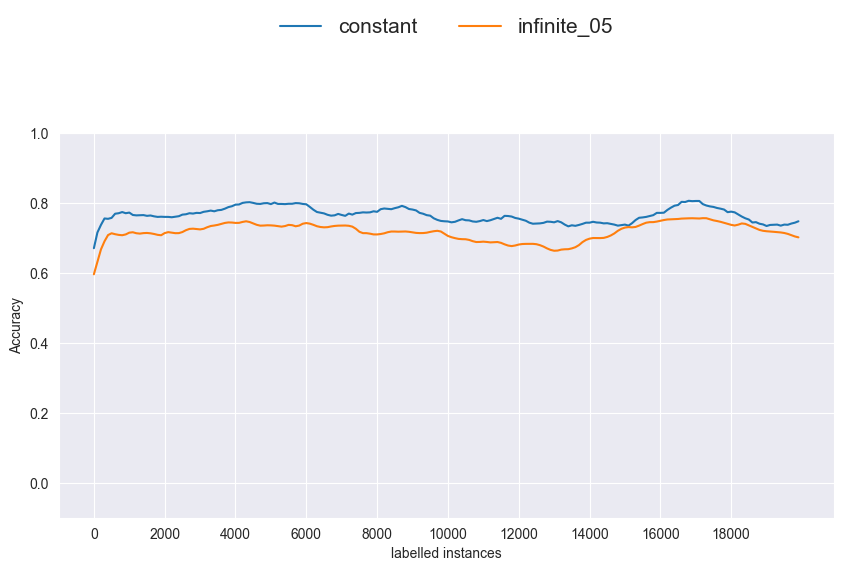

RBF_fast
100
INB


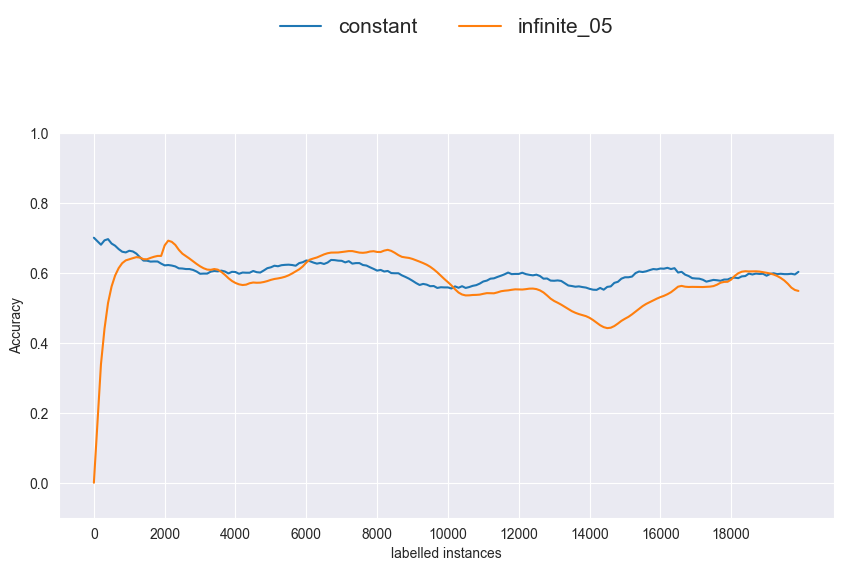

RBF_fast
[Errno 2] No such file or directory: 'logs_formatted\\RBF_fast\\HT_infinite_05.csv' RBF_fast HT
RBF_fast
[Errno 2] No such file or directory: 'logs_formatted\\RBF_fast\\ICLC_infinite_05.csv' RBF_fast ICLC


In [33]:
mpl.rcParams["legend.loc"] = 'best' 
metric = 'Accuracy'
with_saving_table = True
with_rolling = True
agg_type = 'labelled instances'
dataset = 'RBF_fast'
types = ['delay']
thresholds = [0.7]
probabilities = [0]



for method in ['ARF','NB','HT','ICLC']: # os.listdir('logs_formatted'):
    method_logs = pd.DataFrame()
    print(dataset)
    try:
        # :  
        for delay in  ['','_infinite_05']:
            logs = pd.read_csv(os.path.join("logs_formatted",dataset,f"{method}{delay}.csv"))
            logs['classifier']=method
            if delay == '':
                    logs['delay'] = 'constant'
            else:
                    logs['delay']  = delay[1:]
            logs['hyperparameters'] = logs['hyperparameters'].apply(eval)
            if method in    ['ARF','HT','NB','HT_with_params']    :           
                logs = logs[logs['threshold'].apply(lambda t: t  in thresholds)]
            logs = logs[logs['type'].apply(lambda t: t  in types)]
            # # # 
            logs['probability'] = logs['probability'].fillna(0)
            # logs= logs[logs['probability'].apply(lambda x : x in probabilities )]
            logs['classifier'] = logs['classifier'].apply(lambda x: ACC_dict[x])
            if delay in ['_infinite_07','_infinite_05']:
                new_len = 200
                y_original = [float(m) for m in logs[[f'm_{i}' for i in range(new_len)]].iloc[0].values if m!=' '] 
                print(len(y_original))
                delta = (len(y_original)-1) / (new_len-1)
                outp = [interpolate(y_original, i*delta) for i in range(new_len)]
                logs[[f'm_{i}' for i in range(new_len)]] = outp





            method_logs = pd.concat([method_logs, logs], axis = 0)
            method_logs = method_logs.drop_duplicates(subset = ['classifier','delay'],keep = 'last')
         

                
                
    
        if with_rolling:
            method_logs = method_logs.reset_index(drop = True)
            m_cols = [col for col in method_logs.columns if col.startswith('m_')]
            for i in range(method_logs.shape[0]):   
                if method_logs.iloc[i,4] != 0.9:                    
                    method_logs.loc[i,m_cols] = method_logs.loc[i,m_cols].replace(' ', np.nan)               
                    method_logs.loc[i,m_cols] = method_logs.loc[i,m_cols].rolling(20,min_periods = 1).mean()
        # tmp = method_logs[['classifier','probability','B_1','B_15','B_40','B_52']]
        # tmp['classifier'] = tmp['classifier'].apply(lambda x : x.replace('_','\_'))
        # if metric == 'Accuracy':
        #     for c in ['B_1','B_15','B_40','B_52']:
        #         tmp[c] = tmp[c]*100
        # if with_saving_table:
        #     print('________________',dataset,'____________________')
        #     t = get_latex(tmp.sort_values(by = ['probability','classifier'], ascending = [True, False]), f'tab:res_1:{dataset}',f'{metric} for {dataset}')

        plot_method_comparison(logs = method_logs,dataset = dataset, agg_type = agg_type, with_saving=with_saving_table,save_table=False,descriptive_var ='delay',filter_name = 'classifier', metric = metric)
    except Exception as e:
        print(e,dataset, method)
    
   

In [95]:
logs.to_csv(os.path.join("logs_formatted",'AGRAWAL',f"NoChange_kappa.csv"), index=False)

In [91]:
logs = pd.read_csv(os.path.join("logs_formatted",'AGRAWAL',f"NoChange_kappa.csv"))
logs

,stream,hyperparameters,date,type,probability,classifier,threshold,B,frequency,B_1,...,m_190,m_191,m_192,m_193,m_194,m_195,m_196,m_197,m_198,m_199
0,AGRAWAL_0_20000,"{'threshold': '0.7', 'train_period': '0', 'cla...",08-Jul-23 13:32:33,init,NaN,<class 'river.dummy.NoChangeClassifier'>,0.7,50,100,0.000000,...,-0.86,-0.72,-0.86,-0.62,-0.78,-0.8,-0.76,-0.84,-0.78,-0.8
1,AGRAWAL_0_20000_constant_delay,"{'threshold': '0.7', 'train_period': '0', 'cla...",08-Jul-23 13:33:03,delay,NaN,<class 'river.dummy.NoChangeClassifier'>,0.7,50,100,-0.003933,...,-0.86,-0.72,-0.86,-0.62,-0.78,-0.8,-0.76,-0.84,-0.78,-0.8
2,AGRAWAL_0_20000_constant_delay_ssl_0.1_0_20000,"{'threshold': '0.7', 'train_period': '0', 'cla...",08-Jul-23 13:34:08,ssl,0.1,<class 'river.dummy.NoChangeClassifier'>,0.7,50,100,-0.000297,...,,,,,,,,,,
3,AGRAWAL_0_20000_constant_delay_ssl_0.2_0_20000,"{'threshold': '0.7', 'train_period': '0', 'cla...",08-Jul-23 13:34:25,ssl,0.2,<class 'river.dummy.NoChangeClassifier'>,0.7,50,100,-0.000633,...,,,,,,,,,,
4,AGRAWAL_0_20000_constant_delay_ssl_0.9_0_20000,"{'threshold': '0.7', 'train_period': '0', 'cla...",19-Jul-23 18:18:55,ssl,0.9,<class 'river.dummy.NoChangeClassifier'>,0.7,50,100,0.015536,...,,,,,,,,,,
5,AGRAWAL_0_20000_constant_delay_ssl_0.4_0_20000,"{'threshold': '0.7', 'train_period': '0', 'cla...",19-Jul-23 18:20:08,ssl,0.4,<class 'river.dummy.NoChangeClassifier'>,0.7,50,100,0.007210,...,,,,,,,,,,
6,AGRAWAL_0_20000_constant_delay_ssl_0.9_0_20000,"{'threshold': '0.7', 'train_period': '0', 'cla...",26-Jul-23 15:19:14,ssl,0.9,<class 'river.dummy.NoChangeClassifier'>,0.7,50,100,0.029830,...,,,,,,,,,,
7,AGRAWAL_0_20000_constant_delay_ssl_0.4_0_20000,"{'threshold': '0.7', 'train_period': '0', 'cla...",26-Jul-23 17:23:18,ssl,0.4,<class 'river.dummy.NoChangeClassifier'>,0.7,50,100,-0.003873,...,,,,,,,,,,
8,AGRAWAL_0_20000_constant_delay_ssl_0.9_0_20000,"{'threshold': '0.7', 'train_period': '0', 'cla...",26-Jul-23 15:29:44,ssl,0.9,<class 'river.dummy.NoChangeClassifier'>,0.7,50,100,0.040532,...,,,,,,,,,,
9,AGRAWAL_0_20000_constant_delay_ssl_0.4_0_20000,"{'threshold': '0.7', 'train_period': '0', 'cla...",26-Jul-23 17:32:42,ssl,0.4,<class 'river.dummy.NoChangeClassifier'>,0.7,50,100,-0.002948,...,,,,,,,,,,


In [75]:
for method in ['HT']:

    logs = pd.read_csv(os.path.join("logs_formatted",'RBF_moderate',f"{method}.csv"))
    logs['B_2'] = (logs['B_1'] + logs['B_3'])/2
    logs['B_51'] = (logs['B_52'] + logs['B_50'])/2
    logs.to_csv(os.path.join("logs_formatted",'RBF_moderate',f"{method}.csv"), index = False)
    logs['B_2']

ARF_infinite_05.csv


C:\Users\gosia\AppData\Local\Temp\ipykernel_32480\808610342.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['types_of_data'] = tmp.apply(lambda r: "_".join([str(r[col]) if not pd.isna(r[col]) else "" for col in descriptive_vars ]) ,axis =1)


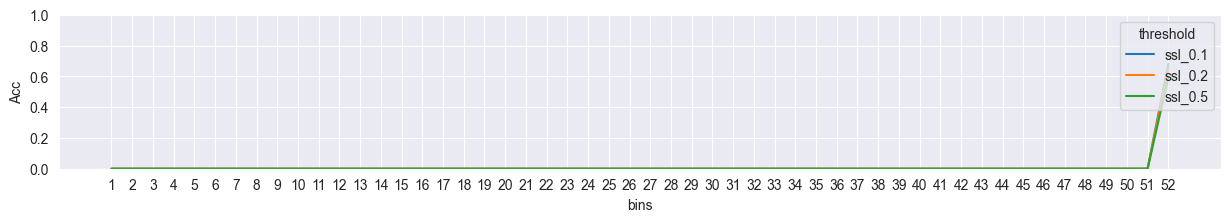

local variable 'table' referenced before assignment
Clustream.csv


C:\Users\gosia\AppData\Local\Temp\ipykernel_32480\808610342.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['types_of_data'] = tmp.apply(lambda r: "_".join([str(r[col]) if not pd.isna(r[col]) else "" for col in descriptive_vars ]) ,axis =1)


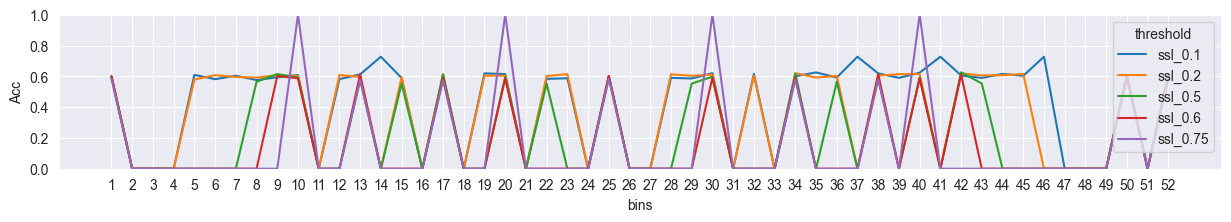

local variable 'table' referenced before assignment


In [16]:

for dataset in ['RBF_fast']:
    for method in ['ARF_infinite_05.csv','Clustream.csv']:

        try:
            logs = pd.read_csv(os.path.join("logs_formatted",dataset,f"{method}"))
            #logs = logs[logs['threshold'].apply(lambda x: x in [0.9,0.7,0.5,1.0])]
            # logs = logs[logs['probability'].apply(lambda x: x in [0.5,0.2,0.1])]
            # logs = logs.sort_values('threshold')
            # logs['threshold'] = logs.apply(lambda x: None if x['type']=='lfs' else x['threshold'],axis =1)
            # logs = logs.drop_duplicates(subset = ['type','threshold','probability'])
            directory = os.path.join('images',dataset,method[:-4])
            if not os.path.exists(directory):
                os.makedirs(directory)
            print(method)
            table = plot_bins_diff(logs = logs,method = method[:-4],dataset = dataset,agg_type = 'bins',types=types, with_saving=True,save_table=False,descriptive_vars =['type','probability'])
        except Exception as e:
            print(e)
            pass
        

In [ ]:

for dataset in ['RBF_fast']:
    for method in ['ARF_infinite_05.csv','ARF.csv','Clustream.csv']:

        try:
            logs = pd.read_csv(os.path.join("logs_formatted",dataset,f"{method}"))
            #logs = logs[logs['threshold'].apply(lambda x: x in [0.9,0.7,0.5,1.0])]
            # logs = logs[logs['probability'].apply(lambda x: x in [0.5,0.2,0.1])]
            # logs = logs.sort_values('threshold')
            # logs['threshold'] = logs.apply(lambda x: None if x['type']=='lfs' else x['threshold'],axis =1)
            # logs = logs.drop_duplicates(subset = ['type','threshold','probability'])
            directory = os.path.join('images',dataset,method[:-4])
            if not os.path.exists(directory):
                os.makedirs(directory)
            print(method)
            table = plot_bins_diff(logs = logs,method = method[:-4],dataset = dataset,agg_type = 'labelled instances',types=types, with_saving=True,save_table=False,descriptive_vars =['type'], filter = 'probability')
        except Exception as e:
            print(e)
            pass
        

ARF_infinite_05.csv
list index out of range
ARF.csv


In [108]:
logs['probability'].value_counts()

probability
0.90    6
0.75    5
0.60    4
Name: count, dtype: int64

# Histograms

In [59]:
os.listdir('distribution')

['ARF_LED_abrubt.pkl',
 'big_comaprison_1805.pkl',
 'cover05-1.pkl',
 'cover07.pkl',
 'cover09.pkl',
 'covermajority.pkl',
 'covertype_2005.pkl',
 'CoverType_mymethod.pkl',
 'LED_abrubt1.pkl',
 'LED_abrubt_high_probas.pkl',
 'LED_gradual1.pkl',
 'my_method.pkl',
 'RBF_fast_1.pkl',
 'RBF_fast_1_0.5.pkl',
 'RBF_HT_with_depth.pkl',
 'RBF_moderate_1.pkl',
 'rbf_moderate_1805.pkl',
 'test.pkl']

In [62]:
import pickle

# save dictionary to person_data.pkl file
with open(f'distribution\\rbf_moderate_1805.pkl', 'rb') as fp:
    res = pickle.load(fp)

In [56]:
def plot_histograms(res, with_saving = False):
    for q,streams in res.items():
        for stream in streams:
            stream_name = stream[0]
            if 'lfs' not in stream_name and 'init' not in stream_name:
                fig, ax = plt.subplots(1,len(stream[1]),figsize=(5*len(stream[1]),4),sharex=True) 
                if len(stream[1]) ==1:
                    method_name = list(stream[1].keys())[0]
                    method = list(stream[1].values())[0]
                    ax.hist(method[2],bins = 10)
                    ax.set_title(method_name)
                    ax.set(ylabel = "Number of instances",xlabel = "Prediction confidence")
                else:
                    for i,(method_name,method) in enumerate(stream[1].items()):
                        ax[i].hist(method[2],bins = 10)
                        ax[i].set_title(method_name)
                        if i ==0:
                            ax[i].set(ylabel = "Number of instances",xlabel = "Prediction confidence")
                        else:
                            ax[i].set(ylabel = "",xlabel = "Prediction confidence")
                plt.suptitle(stream_name, size=16, y=1)  
                if with_saving:     
                    plt.savefig(os.path.join('distribution_plots',f'{stream_name+";"+";".join([k for k in stream[1].keys()])}.pdf'), format="pdf", bbox_inches="tight")
                plt.show()

In [53]:
def plot_histogramsfor_method(res,method_name, folder = '',with_saving = False):
    for q,streams in res.items():
        streams_used = [s for s in streams if 'lfs' not in s[0] and 'init'not in s[0]]
        # fig, ax = plt.subplots(1,len(streams_used),figsize=(5*len(streams_used),4), sharex=True) 
        for i,stream in enumerate(streams_used):
            stream_name =  re.search('(delay(_ssl_\d.\d+)?)',stream[0]).group(1)
            method = stream[1][method_name]
            g = sns.histplot(method[2],bins = 20)
            g.set(ylabel = "Number of instances",xlabel = "Prediction confidence")
            if with_saving: 
                directory  = os.path.join('distribution_plots',folder)
                if not os.path.exists(directory):
                    os.makedirs(directory)    
                plt.savefig(os.path.join(directory,f'{stream_name}.pdf'), format="pdf", bbox_inches="tight")
            plt.show()

In [82]:
res[(0, 20000)][1][1]['ARF1']

3

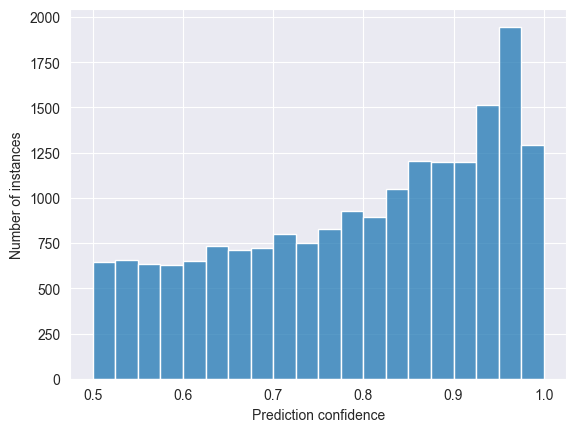

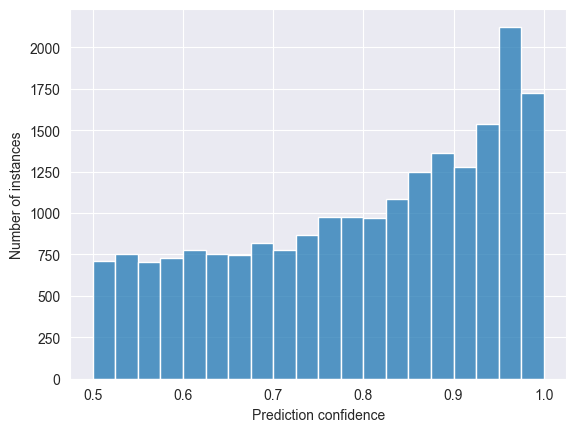

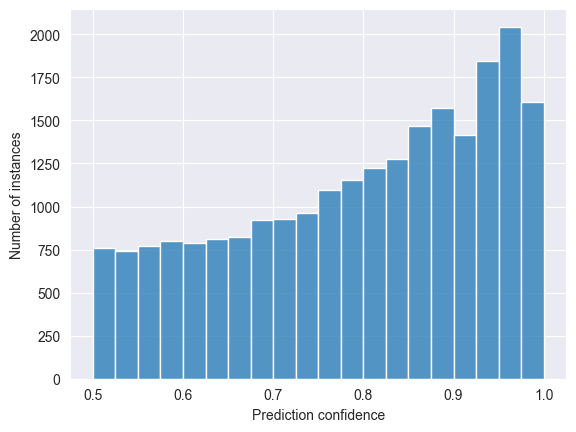

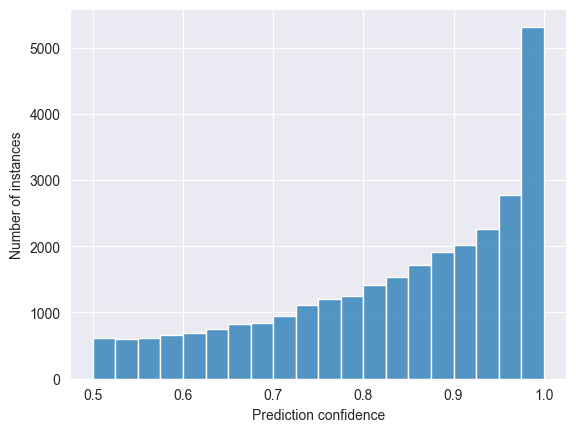

In [66]:
plot_histogramsfor_method(res, 'ARF07',"ARF threshold 0.7 - RBF moderate",True)

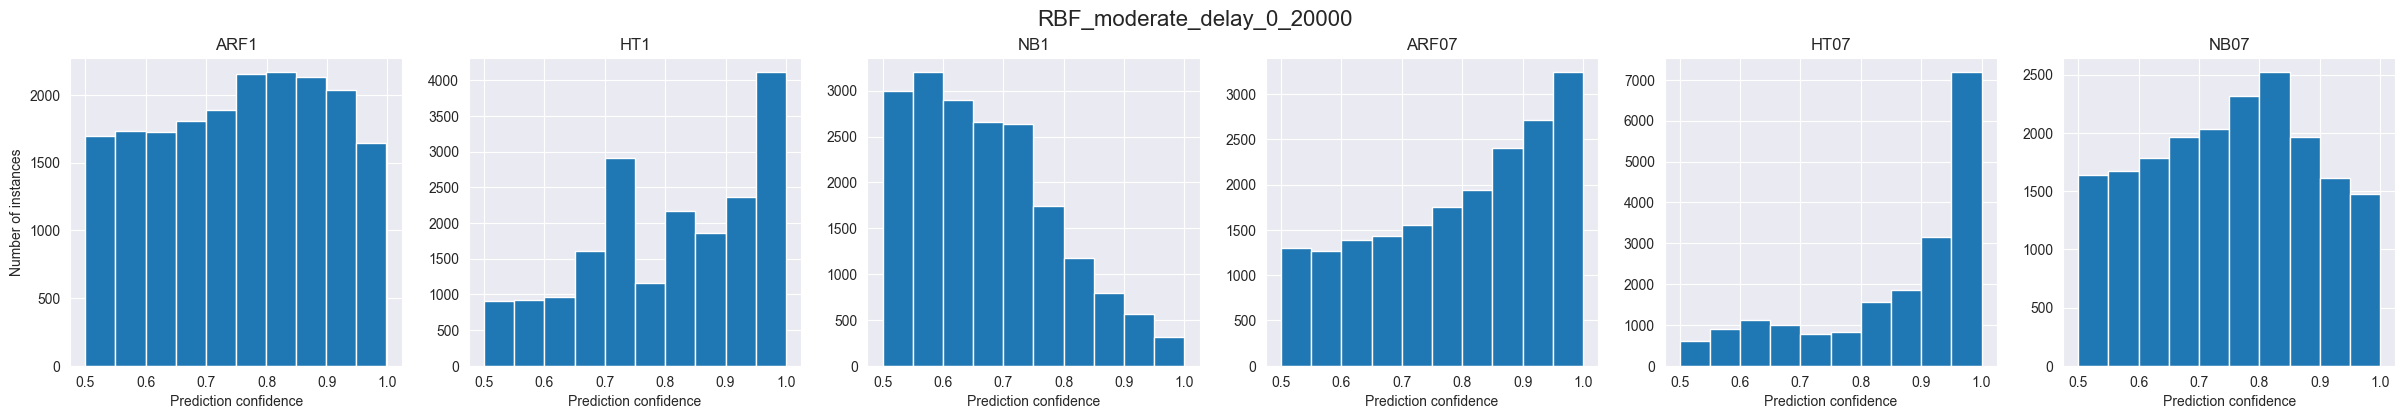

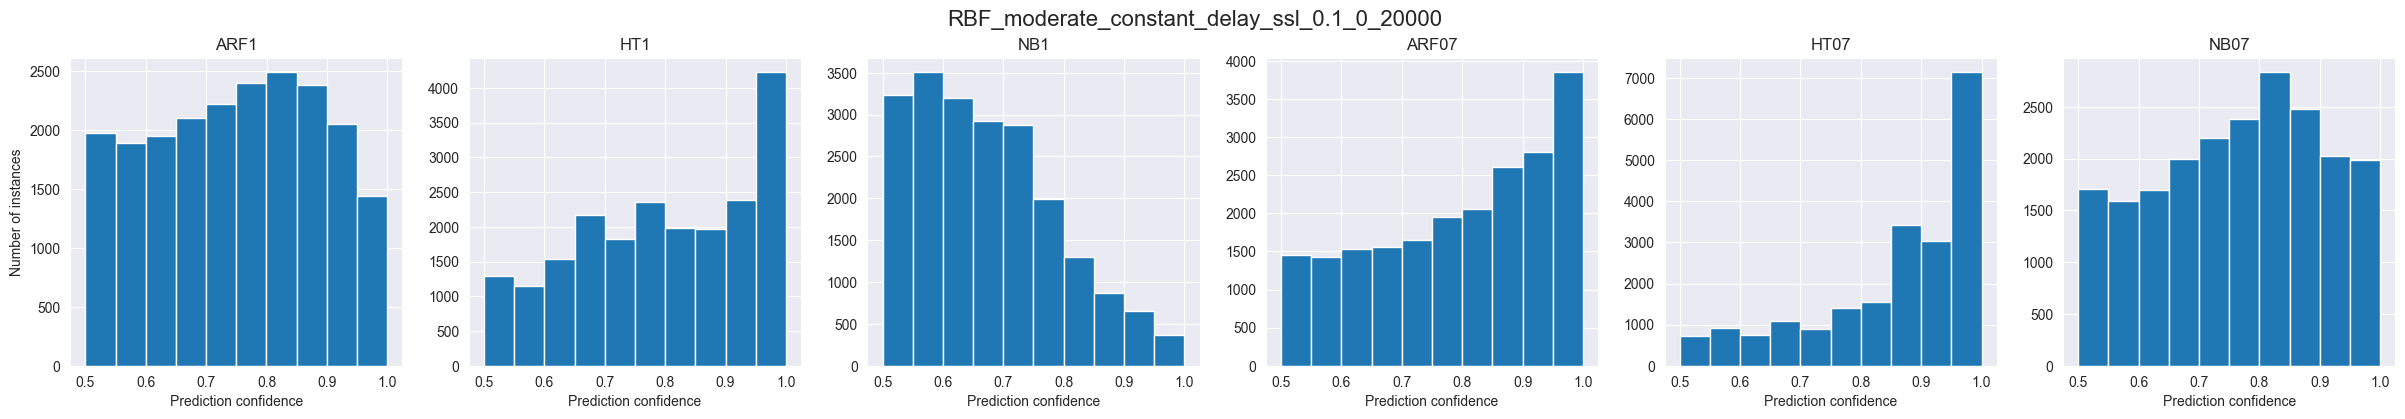

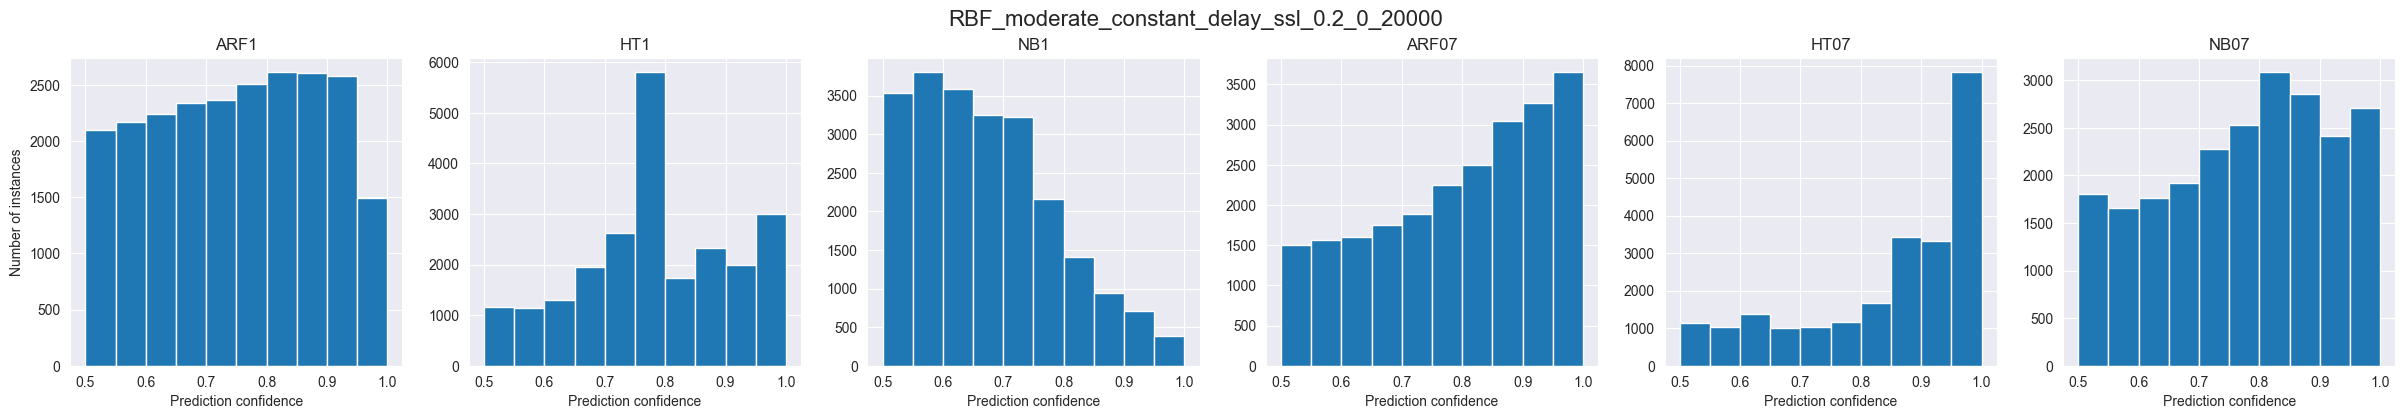

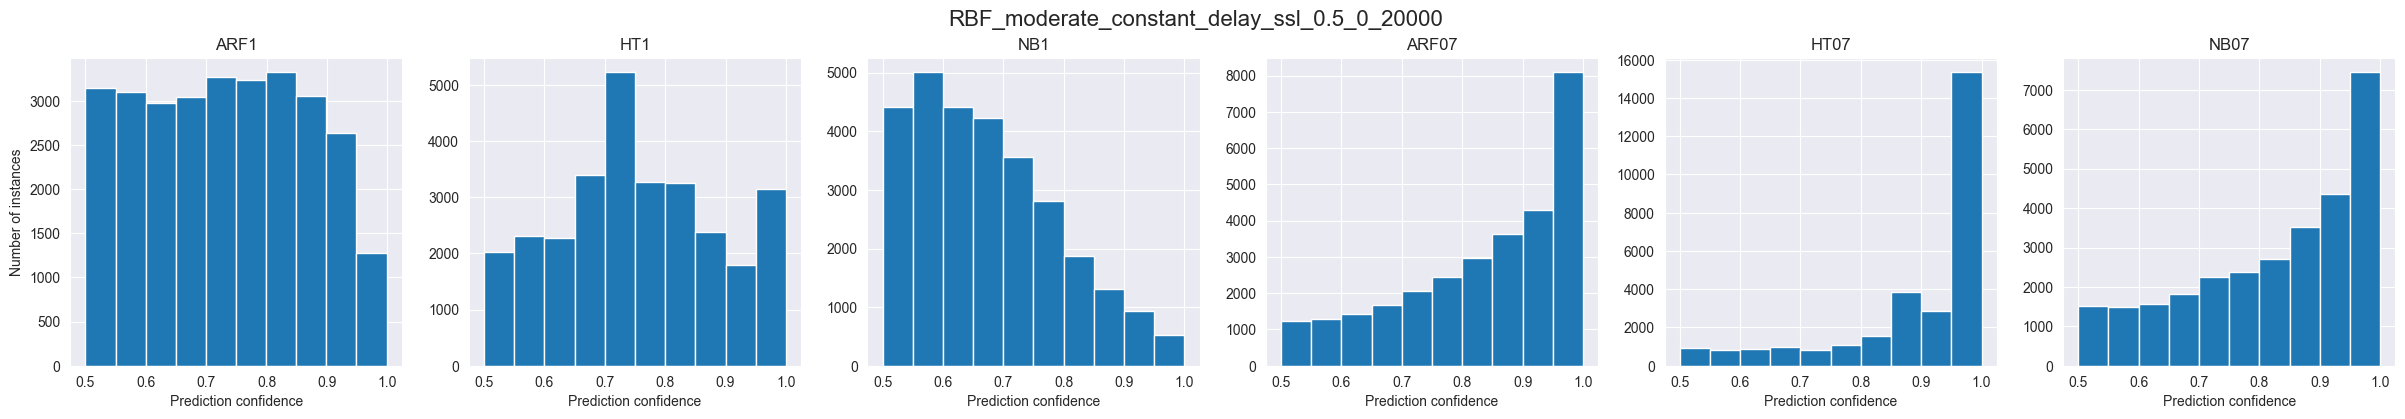

In [63]:
plot_histograms(res)

## Save to latex

In [ ]:
latex_code = table.to_latex(na_rep = '')
latex_code = latex_code.replace("\\\n", "\\ \hline\n")
latex_code = latex_code.replace("\\toprule", "")
latex_code = latex_code.replace("\\midrule", "")
latex_code = latex_code.replace("\\bottomrule", "")
print(latex_code)

C:\Users\gosia\AppData\Local\Temp\ipykernel_43672\417934100.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_code = table.to_latex(na_rep = '')


\begin{tabular}{llrlll}

{} &   type &  probability &   B\_1 &  B\_45 &  B\_52 \\ \hline

38 &  delay &              &  0.81 &  0.83 &  0.83 \\ \hline
37 &  delay &              &  0.81 &  0.83 &  0.83 \\ \hline
31 &  delay &              &  0.75 &  0.81 &  0.80 \\ \hline
14 &  delay &              &  0.75 &  0.81 &  0.81 \\ \hline
13 &  delay &              &  0.75 &  0.83 &  0.82 \\ \hline
12 &  delay &              &  0.85 &  0.86 &  0.86 \\ \hline
29 &   init &              &  0.00 &  0.00 &  0.87 \\ \hline
27 &   init &              &  0.00 &  0.00 &  0.87 \\ \hline
25 &   init &              &  0.00 &  0.00 &  0.87 \\ \hline
5  &   init &              &  0.00 &  0.00 &  0.87 \\ \hline
3  &   init &              &  0.00 &  0.00 &  0.87 \\ \hline
0  &   init &              &  0.00 &  0.00 &  0.87 \\ \hline
28 &    lfs &          0.1 &  0.00 &  0.00 &  0.87 \\ \hline
26 &    lfs &          0.1 &  0.00 &  0.00 &  0.87 \\ \hline
24 &    lfs &          0.1 &  0.00 &  0.00 &  0.87 \\ \h